## Making functions to do testing either A/B or multivariant

Pulling from: 
https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/

https://www.evanmiller.org/bayesian-ab-testing.html#binary_abc

As well as his resources sited. This is very comprehensive and theoretical. It's honestly the best way to explain the process of testing and experimental design.

In [1]:
import pymc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# @pymc.deterministic
# def delta(p_A = p_A, p_B = p_B):
#     return p_B - p_A
def split_testing(a_dist,b_dist):
    p_A = pymc.Uniform('p_A', 0, 1)
    p_B = pymc.Uniform('p_B', 0, 1)
    @pymc.deterministic
    def delta(p_A = p_A, p_B = p_B):
        return p_B - p_A
    obs_A = pymc.Bernoulli('obs_A', p_A, value = values_A , observed = True)
    obs_B = pymc.Bernoulli('obs_B', p_B, value = values_B , observed = True)
    model = pymc.Model([p_A, p_B, delta, values_A, values_B])
    mcmc = pymc.MCMC(model)
    mcmc.sample(1000000, 500000)
    siteA_distribution = mcmc.trace("p_A")[:]
    siteB_distribution = mcmc.trace("p_B")[:]
    delta_distribution = mcmc.trace('delta')[:]
    print("Probability that  A > B: %0.3f" % (delta_distribution < 0).mean())
    print()
    print ("Probability that A < B: %0.3f" % (delta_distribution > 0).mean())
    sns.kdeplot(delta_distribution, shade = True)
    plt.axvline(0.00, color = 'black')
    return(model)

In [ ]:
values_A = np.hstack(([0]*(1055-28),[1]*28))
# Website B had 1057 clicks and 45 sign-ups
values_B = np.hstack(([0]*(1057-45),[1]*45))
split_testing(values_A,values_B)

## Incorporating Hierachical Models

In [3]:
def multi_split_testing(trials_list,successes_list):
    trials = trials_list
    successes = successes_list
    @pymc.stochastic(dtype=np.float64)
    def beta_priors(value=[1.0, 1.0]):
        a, b = value
        if a <= 0 or b <= 0:
            return -np.inf
        else:
            return np.log(np.power((a + b), -2.5))
    a = beta_priors[0]
    b = beta_priors[1]
    #The hidden, true rate for each website.
    true_rates = pymc.Beta('true_rates', a, b, size=len(trials_list))
    # This is what we observed
    observed_values = pymc.Binomial('observed_values', trials_list, true_rates, observed=True, value=successes)
    model = pymc.Model([a, b, true_rates, observed_values])
    mcmc = pymc.MCMC(model)
    # Generate 1M samples, and throw out the first 500k
    mcmc.sample(1000000, 500000)
    for i in range(5):
        sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "%s" % chr(65+i))

In [ ]:
trials = np.array([1055, 1057, 1065, 1039, 1046])

successes = np.array([28, 45, 69, 58, 60])

multi_split_testing(trials,successes)

## Lets incorporate a class structure to make this more user friendly

In [7]:
@pymc.stochastic(dtype=np.float64)
## calculating beta_priors a and b
def beta_priors(value=[1.0, 1.0]):
    a, b = value
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))
    
class multi_testing(object):
    def __init__(self,trials,successes,trial_names):
        self.trial_names = trial_names
        self.trials = trials
        self.successes = successes
    def make_model_and_sample(self):
        a = beta_priors[0]
        b = beta_priors[1]
        #The hidden, true rate for each website.
        true_rates = pymc.Beta('true_rates', a, b, size=len(trials))
        # This is what we observed
        observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)
        model = pymc.Model([a, b, true_rates, observed_values])
        self.mcmc = pymc.MCMC(model)
        self.mcmc.sample(1000000, 500000)
    # Generate 1M samples, and throw out the first 500k
    def plot_posteriors(self):
        for i in range(5):
            sns.kdeplot(self.mcmc.trace('true_rates')[:][:,i], shade = True, label = "%s" % trial_names[i])
    def plot_single(self,trial_n):
        sns.kdeplot(self.mcmc.trace('true_rates')[:][:,i], shade = True, label = "%s" % trial_n)
    def plot_delta(self,trial_a,trial_b):
        a_index = self.trial_nemes.find(trial_a)
        b_index = self.trial_names.find(trial_b)
        diff = mcmc.trace('true_rates')[:][:,b_index] - mcmc.trace('true_rates')[:][:,a_index]
        sns.kdeplot(diff, shade = True, label = "Difference site %s - site %s"%(trial_a,trial_b))
        plt.axvline(0.0, color = 'black')

In [8]:
trials = np.array([1055, 1057, 1065, 1039, 1046])
successes = np.array([28, 45, 69, 58, 60])
trial_names = ['a','b','c','d','e']
test_1 = multi_testing(trials,successes,trial_names)

In [9]:
test_1.make_model_and_sample()

 [-----------------100%-----------------] 1000000 of 1000000 complete in 232.0 sec

In [17]:
trial_names.index()

TypeError: index() takes at least 1 argument (0 given)

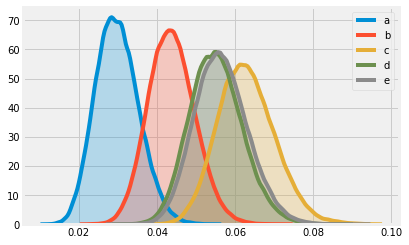

In [10]:
test_1.plot_posteriors()

In [ ]:
test_1.plot_single()